In [1]:
library(SBC);
library(cmdstanr);
library(tidyverse);
options(mc.cores = parallel::detectCores());
library(future);
plan(multisession);

options(SBC.min_chunk_size = 5);

cache_dir <- "./SBC_cache"
if(!dir.exists(cache_dir)) {
    dir.create(cache_dir)
}

model_Poisson_1 <- cmdstanr::cmdstan_model("../models/Poisson_model_1.stan")
model_Poisson_2 <- cmdstanr::cmdstan_model("../models/Poisson_model_2.stan")

This is cmdstanr version 0.7.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/igor.michels/.cmdstan/cmdstan-2.34.1

- CmdStan version: 2.34.1

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message in readLines(stan_file):
“linha final incompleta encontrada em '../models/Poisson_model_1.stan'”
Warning message in readLines(stan_file):
“linha final incompleta encontrada em '../models/Poisson_model_2.stan'”


In [2]:
data_generator_single_Poisson_1 <- function(n_clubs){
    n_seasons <- 1
    clubs <- sprintf("Club %02d", 1:n_clubs)
    clubs <- 1:n_clubs
    force <- abs(rnorm(length(clubs)))
    df <- data.frame(Club = clubs, Force = force)
    data <- merge(df, df, by = NULL) %>% filter(Club.x != Club.y)
    data <- data %>% slice(rep(row_number(), n_seasons))
    data$home.goals <- rpois(nrow(data), data$Force.x / data$Force.y)
    data$away.goals <- rpois(nrow(data), data$Force.y / data$Force.x)
    names(data) <- c("home_name", "home_force", "away_name", "away_force",
                     "home_goals", "away_goals")

    list(
        variables = list(
            habilidade = force
        ),
        generated = list(
            num_jogos = nrow(data),
            num_equipes = n_clubs,
            equipe1 = data$home_name,
            equipe2 = data$away_name,
            gols_equipe1 = data$home_goals,
            gols_equipe2 = data$away_goals
        )
    )
}

In [3]:
data_generator_single_Poisson_2 <- function(n_clubs){
    n_seasons <- 1
    clubs <- sprintf("Club %02d", 1:n_clubs)
    clubs <- 1:n_clubs
    force <- abs(rnorm(length(clubs)))
    home_force <- abs(rnorm(1))
    df <- data.frame(Club = clubs, Force = force)
    data <- merge(df, df, by = NULL) %>% filter(Club.x != Club.y)
    data <- data %>% slice(rep(row_number(), n_seasons))
    data$home.goals <- rpois(nrow(data), (data$Force.x + home_force) / data$Force.y)
    data$away.goals <- rpois(nrow(data), data$Force.y / data$Force.x)
    names(data) <- c("home_name", "home_force", "away_name", "away_force",
                     "home_goals", "away_goals")

    list(
        variables = list(
            habilidade = force,
            home_force = home_force
        ),
        generated = list(
            num_jogos = nrow(data),
            num_equipes = n_clubs,
            equipe1 = data$home_name,
            equipe2 = data$away_name,
            gols_equipe1 = data$home_goals,
            gols_equipe2 = data$away_goals
        )
    )
}

In [4]:
set.seed(0)
n_sims <- 250
data_generator_Poisson_1 <- SBC_generator_function(data_generator_single_Poisson_1, n_clubs = 20)
dataset_Poisson_1 <- generate_datasets(data_generator_Poisson_1, n_sims)
backend_Poisson_1 <- SBC_backend_cmdstan_sample(model_Poisson_1, iter_warmup = 2000,
                                                iter_sampling = 2500, chains = 4)

results_Poisson_1 <- compute_SBC(dataset_Poisson_1, backend_Poisson_1,
                                 cache_mode = "results",
                                 cache_location = file.path(cache_dir, "results_Poisson_1"))
    
write.csv(results_Poisson_1$stats,
          file = "SBC_cache/results_Poisson_1.csv")

Results loaded from cache file 'results_Poisson_1'

 - 109 (44%) fits had at least one Rhat > 1.01. Largest Rhat was 1.032.

 - 50 (20%) fits had tail ESS undefined or less than half of the maximum rank, potentially skewing 
the rank statistics. The lowest tail ESS was 240.
 If the fits look good otherwise, increasing `thin_ranks` (via recompute_SBC_statistics) 
or number of posterior draws (by refitting) might help.

Not all diagnostics are OK.
You can learn more by inspecting $default_diagnostics, $backend_diagnostics 
and/or investigating $outputs/$messages/$warnings for detailed output from the backend.



In [5]:
set.seed(0)
n_sims <- 250
data_generator_Poisson_2 <- SBC_generator_function(data_generator_single_Poisson_2, n_clubs = 20)
dataset_Poisson_2 <- generate_datasets(data_generator_Poisson_2, n_sims)
backend_Poisson_2 <- SBC_backend_cmdstan_sample(model_Poisson_2, iter_warmup = 2000,
                                                iter_sampling = 2500, chains = 4)

results_Poisson_2 <- compute_SBC(dataset_Poisson_2, backend_Poisson_2,
                                 cache_mode = "results",
                                 cache_location = file.path(cache_dir, "results_Poisson_2"))
    
write.csv(results_Poisson_2$stats,
          file = "SBC_cache/results_Poisson_2.csv")

Results loaded from cache file 'results_Poisson_2'

 - 103 (41%) fits had at least one Rhat > 1.01. Largest Rhat was 1.034.

 - 64 (26%) fits had tail ESS undefined or less than half of the maximum rank, potentially skewing 
the rank statistics. The lowest tail ESS was 116.
 If the fits look good otherwise, increasing `thin_ranks` (via recompute_SBC_statistics) 
or number of posterior draws (by refitting) might help.

 - 1 (0%) fits had iterations that saturated max treedepth. Maximum number of max treedepth was 3.

Not all diagnostics are OK.
You can learn more by inspecting $default_diagnostics, $backend_diagnostics 
and/or investigating $outputs/$messages/$warnings for detailed output from the backend.



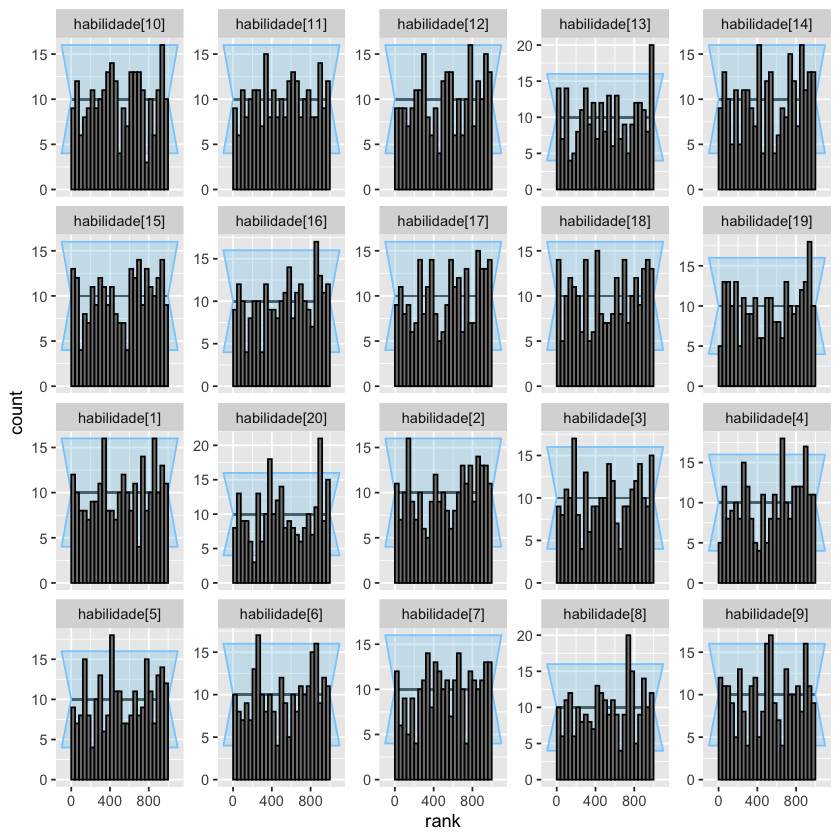

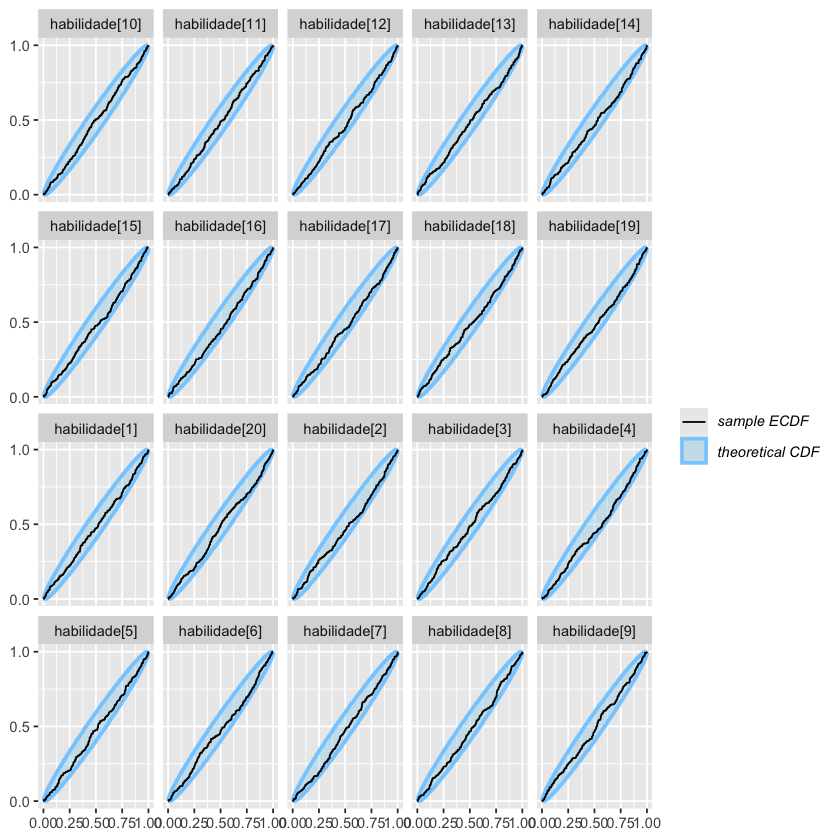

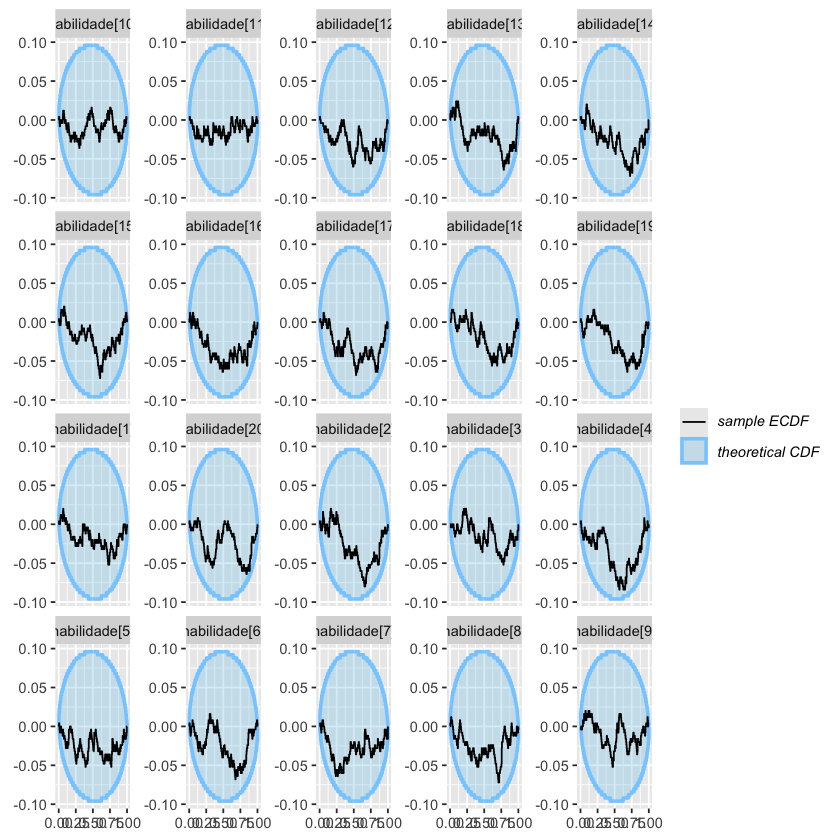

In [6]:
plot_rank_hist(results_Poisson_1)
plot_ecdf(results_Poisson_1)
plot_ecdf_diff(results_Poisson_1)

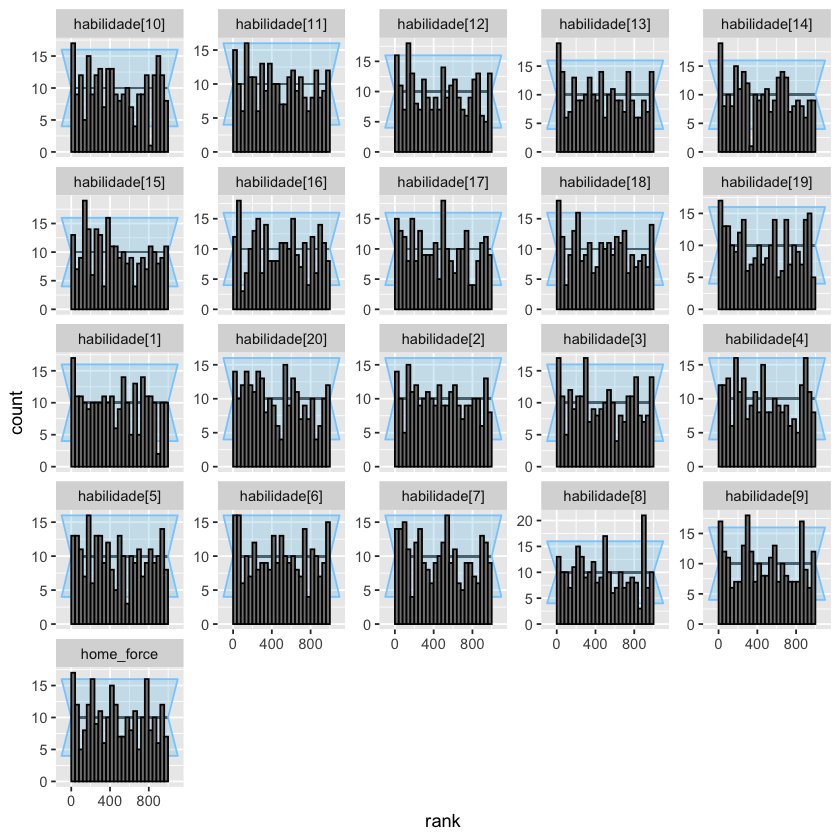

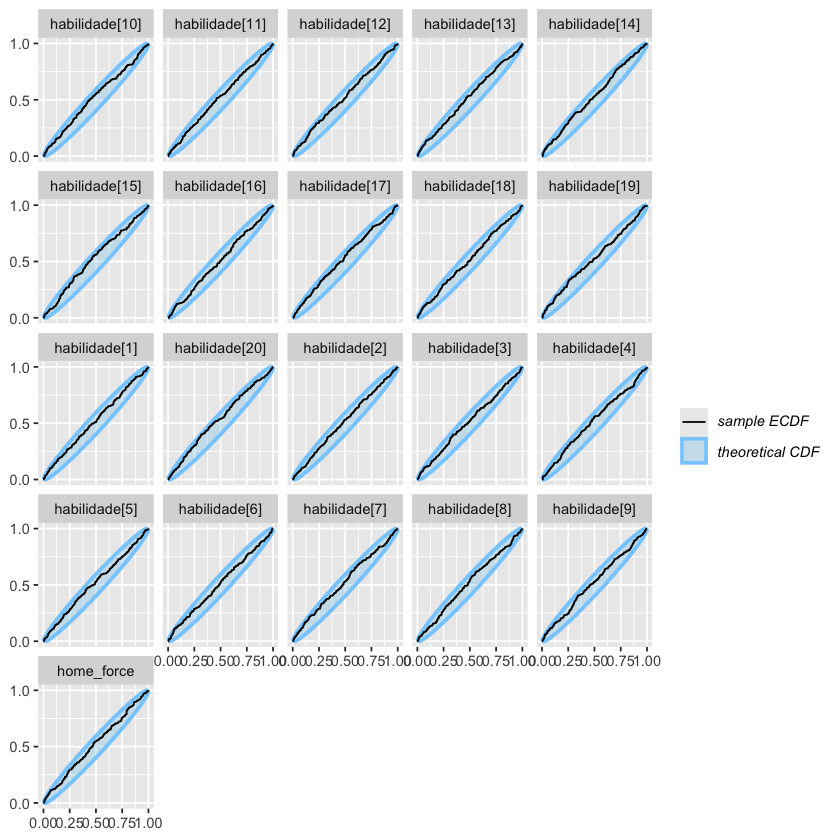

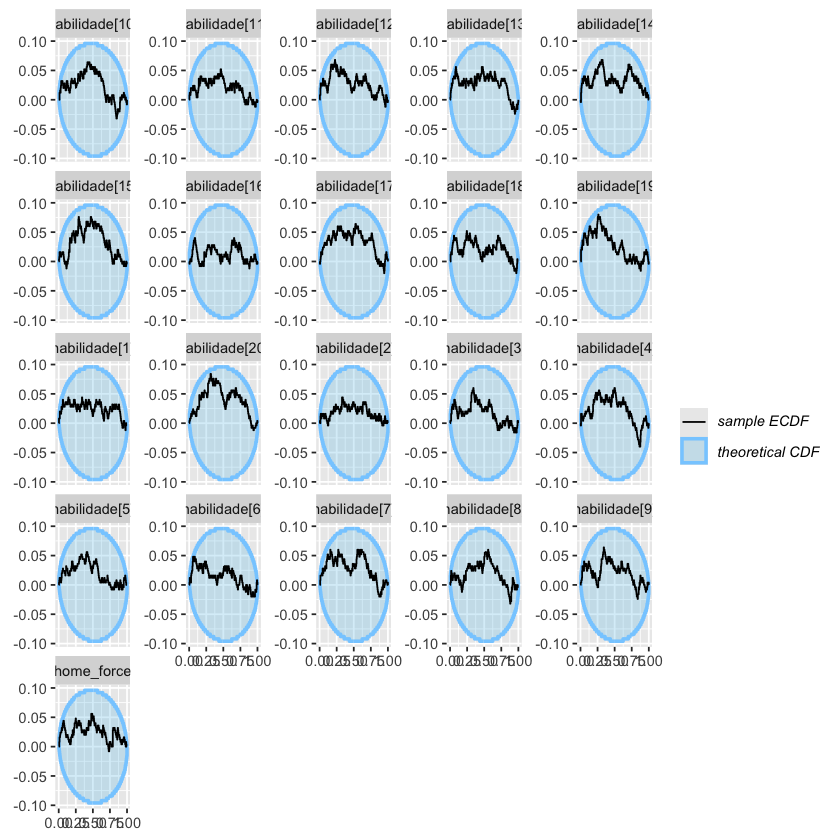

In [7]:
plot_rank_hist(results_Poisson_2)
plot_ecdf(results_Poisson_2)
plot_ecdf_diff(results_Poisson_2)